# MVA - Homework 1 - Reinforcement Learning (2022/2023)

**Name:** CHAUVIN Paul

## Instructions

* The deadline is **November 10 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/l4y5ubadwj64mb/post/6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [1]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [2]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [3]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [4]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [5]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

In the case of an affine transformation applied to the reward and with $\gamma < 1$, the new value function is 

$$ V_{transformed}^{\pi} = E\left[\sum_ {i=0}^\infty 
\gamma^t(ar_t + b)\right]
$$


Hence, $$ V_{transformed}^{\pi} =aV^{\pi} + bE\left[\sum_ {i=0}^\infty 
\gamma^t\right]
$$


Hence, $$ V_{transformed}^{\pi} = aV^{\pi} + \frac{b}{1-\gamma}
$$

The optimal policy is preserved when $a > 0$ but is not preserved when $a \leq 0$

## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**

[your answer here]

## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**
**Value Iteration:**

Pros: each iteration is very computationally efficient

Cons: convergence in only asymptomatic



**Policy Iteration:**

Pros: converge in a finite number of iterations (often small in practice)

Cons: each iteration requires a full policy evaluation and it might be expensive

In [6]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #

    r_k = np.zeros(Ns)
    p_k = np.zeros((Ns,Ns))
    value_function = np.zeros(Ns)
    for s in range(Ns):
      a = policy[s]
      r_k[s] = R[s,a]
      for s_prime in range(Ns):
        p_k[s,s_prime] = P[s,a,s_prime]
    value_function = np.linalg.solve(np.eye(Ns)- gamma*p_k, r_k)
    # ====================================================
    return value_function

In [7]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=int)
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 

    policy_prev = policy.copy()
    V = policy_evaluation(P, R, policy, gamma = gamma, tol = tol)
    V_prev= V.copy()
    flag=True
    while (np.linalg.norm(V - V_prev) > tol or flag ):
      if flag:
        flag = False
      V_prev=V.copy()
      for s in range(Ns):
        policy[s] = np.argmax(R[s] + gamma*np.dot(P[s],V))
      V = policy_evaluation(P, R, policy, gamma = gamma, tol = tol)   

    # ====================================================
    return policy, V  

In [8]:
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    greedy_policy = np.argmax(Q, axis=1)
    V = np.zeros(Ns)
    V_prev = np.zeros(Ns)
    flag=True
    while (np.linalg.norm(V - V_prev) > tol or flag ):
      if flag:
        flag = False
      V_prev=V.copy()
      for s in range(Ns):
          for a in range(Na):
              Q[s,a] = R[s,a]+ gamma*(np.dot(P[s,a],V))
          V[s] = np.max(Q[s])
      Qfs.append(Q.copy())
    greedy_policy = np.argmax(Q,axis = 1)

    # ====================================================
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


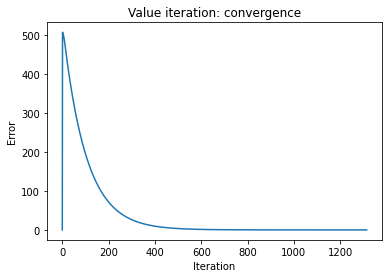

In [9]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================
# YOUR IMPLEMENTATION HERE 
# compute value function of the greedy policy
#
greedy_V = policy_evaluation(env.P, env.R, VI_greedypol, gamma = gamma, tol = tol )

# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
print("\n[PI]final policy: ")
render_policy(env, PI_policy)

## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
  "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
  "Since the policies are equal, even the value function should be"

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

I think that 'get_uniform_dataset' method is more consitent as we are sure that it will sample every actions and states. Whereas 'get_random_policy_dataset' method can result in having unexplored states or actions because it's not sure that it will generate randomly all the space. 

In [10]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset


# Collect two different datasets
num_samples = 500
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


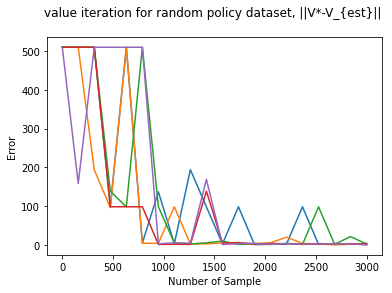

100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


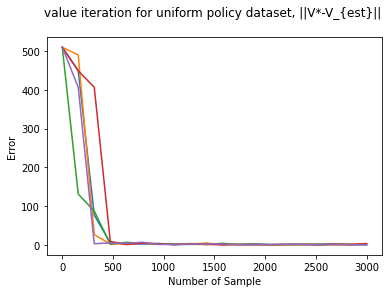

In [11]:
env = get_env()

# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs

tol = 1e-5
gamma = 0.99
N_try=5
Num_samples = np.linspace(1,3000,20,dtype=int)
N_dic={}
dic={}
for dataset_type in ["random","uniform"]:
  dic[dataset_type]=[]
  
  # N_dic[dataset_type]=[]
  for n_try in range(N_try):
    dic[dataset_type]=[]
    for num_samples in tqdm(Num_samples):
      if dataset_type=="random":
        dataset = get_random_policy_dataset(env, num_samples)
      else:
        dataset = get_uniform_dataset(env, num_samples)
      (states, actions, rewards, next_states)=dataset
      Ns,Na = env.R.shape
      P=np.zeros((Ns,Na,Ns))
      R=np.zeros((Ns,Na))
      count_R = np.zeros((Ns,Na))
      count_P = np.zeros((Ns,Na,Ns))
      for (s,a,r,s_prime) in zip(states, actions, rewards, next_states):
        P[s,a,s_prime]+=1
        R[s,a]+=r
        count_R[s,a]+=1
        count_P[s,a,:]+=1
      P[count_P!=0] /= count_P[count_P!=0]
      R[count_R!=0]/=count_R[count_R!=0]


      Q_est, VI_greedypol_est, all_qfunctions_est = value_iteration(P, R, gamma=gamma, tol=tol)
      greedy_V_est = policy_evaluation(P, R, VI_greedypol_est, gamma = gamma, tol = tol )
      final_V_est = all_qfunctions_est[-1].max(axis=1)


      Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)
      greedy_V = policy_evaluation(env.P, env.R, VI_greedypol, gamma = gamma, tol = tol )
      final_V = all_qfunctions[-1].max(axis=1)
      # norms_V = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions_est]
      dic[dataset_type].append(np.linalg.norm(final_V_est - final_V))
    if n_try==0:
      N_dic[dataset_type]=[i/N_try for i in dic[dataset_type].copy()]
    else:
      N_dic[dataset_type] = np.array(N_dic[dataset_type])+np.array(dic[dataset_type].copy())

    # norms_V.append(np.linalg.norm(final_V_est - final_V))
    plt.plot(Num_samples,dic[dataset_type])
  plt.xlabel('Number of Sample')
  plt.ylabel('Error')
  plt.title("value iteration for "+dataset_type+ " policy dataset, ||V*-V_{est}|| \n")
  plt.show()


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**




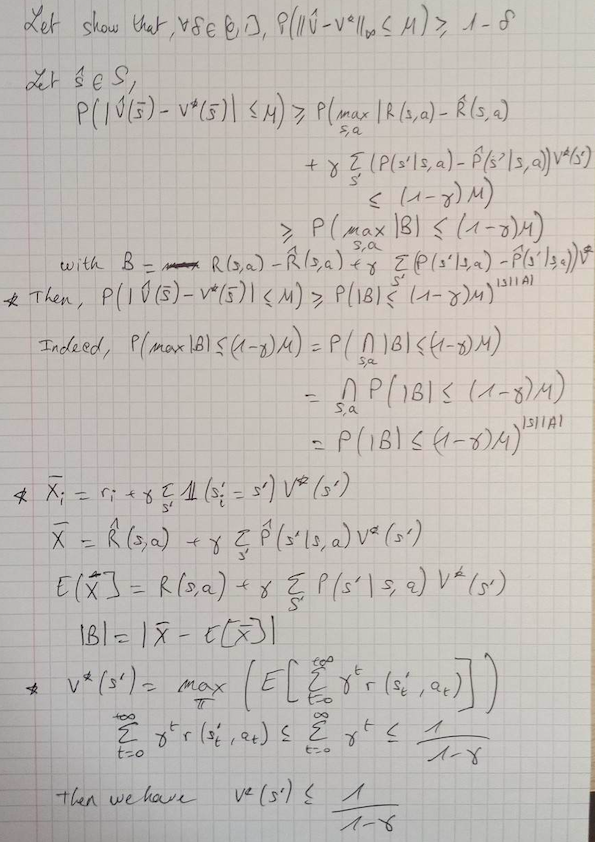




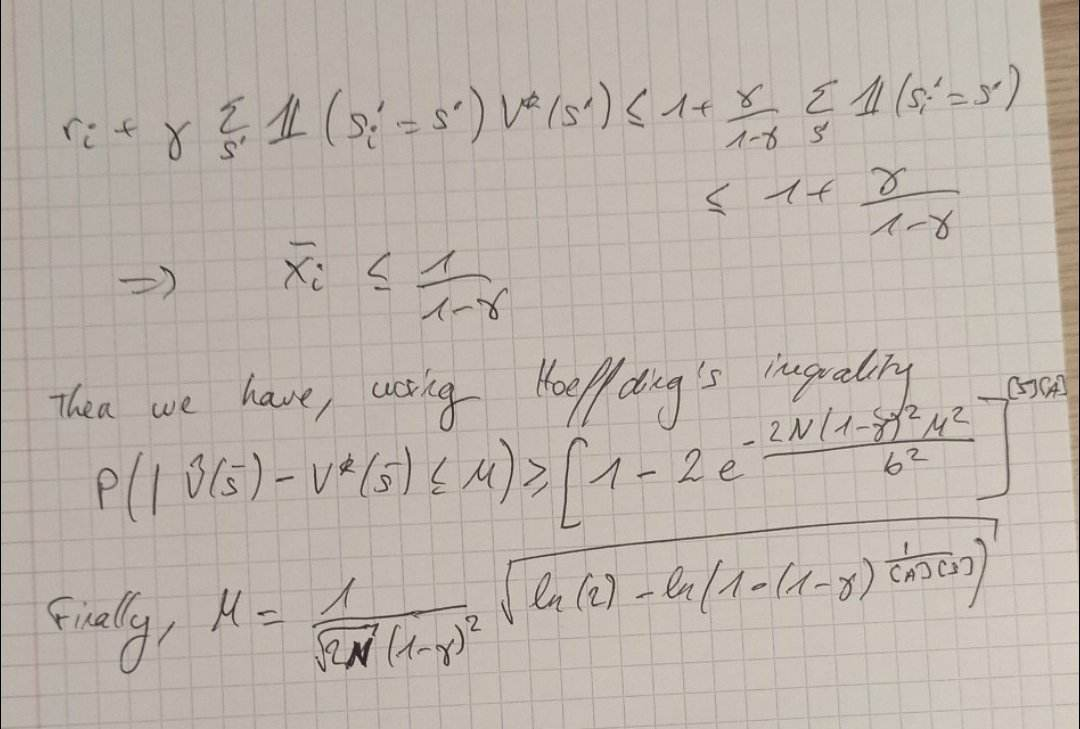

Conclusion:


$$ \mathbb{P}\left(
  \|\hat{V} - V^* \|_\infty
 \leq
\sqrt{\ln\left(\frac{2|S||A|}{\delta}\right)} \frac{1}{\sqrt{2N}(1-\gamma)^2}\right)
\geq 1-\delta
$$

## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

[your answer here]

# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**
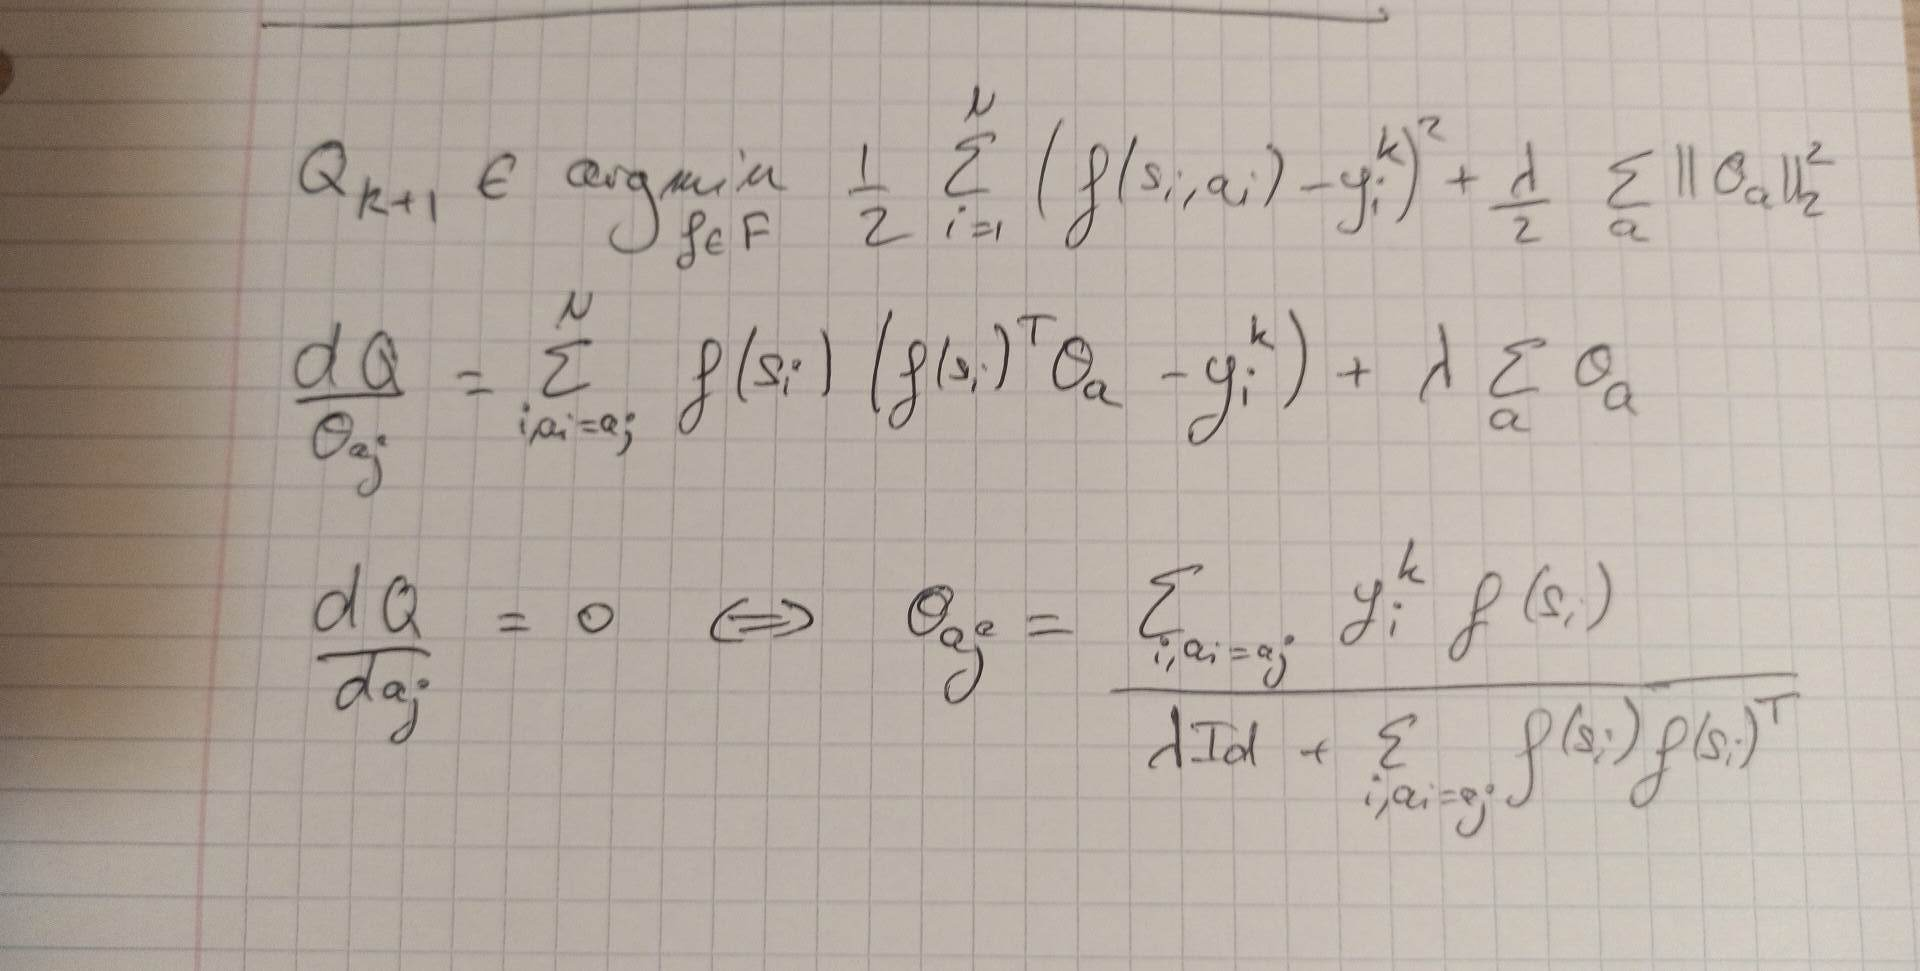

## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

[explanation about how you tried to reduce the approximation error + FQI implementation below]::

In [12]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [13]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[-0.02850699  0.063555   -0.02169407 -0.06441918  0.04505794 -0.07537777
  0.08506473 -0.09325287  0.09644275 -0.00535101  0.11632395 -0.13074085
  0.00921342 -0.13853662  0.07118419]
(15, 4)
[0. 0. 0. 0.]


0


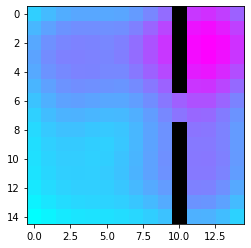

In [14]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
  """
  # Linear FQI implementation
  # TO BE COMPLETED
  """

# get a dataset
  dataset = get_uniform_dataset(env, n_samples=5000)
  #dataset = get_random_policy_dataset(env, n_samples=500)
  (states, actions, rewards, next_states) = dataset 

  cc = 0
  while max(rewards) == 0 and cc < 20  : 
    dataset = get_uniform_dataset(env, n_samples=5000)
    (states, actions, rewards, next_states) = dataset 
    cc +=1
  print(cc)

  Rmax = max(rewards)
  theta = np.zeros((feat_map.dim, env.Na)) 

  for it in range(num_iterations):
    for a in range(env.Na):
      tmp_theta = np.copy(theta) 
      to_inv = 0 
      sum_term = 0
      for i in range(len(actions)):
        if  actions[i] == a :
          to_inv += np.outer(np.array(feat_map.map(states[i])) , np.array(feat_map.map(states[i])) ) 
          f_s_a = max( feat_map.map(next_states[i]) @ tmp_theta ) 
          #clipping 
          if f_s_a > 0 :
            f_s_a = min(f_s_a , Rmax / (1-gamma) )
          else : 
            f_s_a = max(f_s_a, - Rmax/(1-gamma))

          y_i_k = rewards[i] + gamma * f_s_a
          sum_term += y_i_k * feat_map.map(states[i]) 

      to_inv += lambd * np.eye(feat_map.dim)
      theta[:,a] =  np.linalg.inv(to_inv) @ sum_term 
  return theta

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=15, sigma=0.25)

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100)

# Compute and run greedy policy
Q_fqi = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi[ss, :] = state_feat @ theta

V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi)    
plt.imshow(img)
plt.show()